# Get going by asking the following questions and looking for the answers with some code and plots:

Can you count something interesting?

Can you find some trends (high, low, increase, decrease, anomalies)?

Can you make a bar plot or a histogram?

Can you compare two related quantities?

Can you make a scatterplot?

Can you make a time-series plot?

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?


## It would be interesting to look at aggregations of the data keys and time signatures. Then get a closer look at the pitches and durations of notes for the string quartets. 

First the data will need to be setup in a way in which it can be visualized. To do this, each of the string quartet files will need to be parsed and then analyzed for its key and time signatures as well as capturing the pitch name, frequency, and duration for each of the files.

In [1]:
from music21 import *
from collections import Counter
import pandas as pd
import os

s = 'chord'

# It would be interesting to count the keys in the corpus
Keys = []
TimeSign = []

# Note Lists
NoteDuration = []
NotePitches = []
NoteStrPitches = []
NoteFreq = []
NoteAndDuration= []
path = "c:\\users\\qh1444dd\\DeepBach\\datasets\\custom_dataset\\"
for filename in os.listdir(path):
    if filename[-4:] in {'.mid'}: 
        midi = converter.parse(path + filename)
        key = midi.analyze('key')
        Keys.append(key)
        time = midi.recurse().getElementsByClass(meter.TimeSignature)[0]
        TimeSign.append(time)
        for n in midi.flat.notes:
            if not ("chord") in str(n):
                NoteDuration.append(n.beatStrength)
                NotePitches.append(n)
                NoteStrPitches.append(str(n))
                NoteFreq.append(n.ps)
                NoteAndDuration.append([str(n), str(n.beatStrength)])
        else:
            pass


C:\Users\qh1444dd\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: Music21DeprecationWarning: Note._getPs was deprecated on May 2014 and will disappear at or after May 2016. use pitch.ps instead


The follow code takes the list that were instantiated and filled in the for loop and creates a pandas dataframe.

In [2]:
PitchData = pd.DataFrame.from_dict({'NoteDuration': NoteDuration,
                          'NotePitches': NotePitches,
                          'NoteFreq': NoteFreq,
                          'NoteAndDuration': NoteAndDuration})

In [3]:
PitchData['str_NoteAndDuration'] = PitchData.NoteAndDuration.apply(', '.join)

In [6]:
PitchData.to_csv('PitchData.csv')

In [7]:
import os
os.getcwd()

'C:\\Users\\qh1444dd\\SpringBoard_dev\\Capstone 1'

### Key Signature Aggregation

It would be interesting to know the aggregation of the keys in the string quartets. To iterate through a list to get a quick count, the counter function can be used.

In [8]:
key_counts = Counter(Keys)

Next the key counts can be made into a pandas dataframe and sorted by descending counts below.

In [9]:
key_df = pd.DataFrame.from_dict(key_counts, orient='index')
key_df.sort_values([0], ascending=[0])
key_df = key_df.reset_index()
key_df.columns = ['Key', 'Counts']
key_df['Key'] = key_df['Key'].astype(str)

Next, the data will be visualized using the seaborn packages.

 (0, 25),

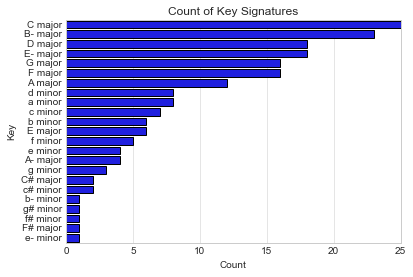

In [10]:
import seaborn as sns
sns.set_style("whitegrid")
key_df = key_df.sort_values("Counts", ascending=False)
ax = sns.barplot(x = key_df['Counts'], y=key_df['Key'], data=key_df,
            label="Total", color="b")
ax.set(xlim=(0, 25), ylabel="Key",
       xlabel="Count", title = "Count of Key Signatures")

It appears that C major is the most popular key in the corpus, Nigel Tufnel from Spinal Tap may have been onto something with d minor being the saddest of all keys, becuase it is the most represented minor key in the data.

### Time Signature Aggregation

First the data needs to be cleaned up, converting from a music21 time object to a str and then stripping out the excess characters.

In [11]:
import re

# Convert Time Signature Values to String
TimeSignList = []
for x in TimeSign:
    TimeSignList.append(str(x))

# Strip out the excess characters from the string values
for i in range(0, len(TimeSignList)):
    TimeSignList[i] = (re.sub('<music21.meter.', '', TimeSignList[i]))
    TimeSignList[i] = (re.sub('>', '', TimeSignList[i]))

After converting to a string, the aggregation calculation can be used for time signatures as well.

In [12]:
TimeSignList_counts = Counter(TimeSignList)

Just as with the key data, the Time Signature data is transformed into a dataframe in the code below.

In [13]:
time_df = pd.DataFrame.from_dict(TimeSignList_counts, orient='index')
time_df.sort_values([0], ascending=[0])
time_df = time_df.reset_index()
time_df.columns = ['Time Signature', 'Counts']

Finally, the data is plotted below. I assumed that 4/4 or some even subdivision would have been the most common time signature, but evidentally 3/4 is slightly more common. It more or less alternates between odd and even time descending by counts. It appears that overall there are more even time signautres then odd.

 (0, 60),

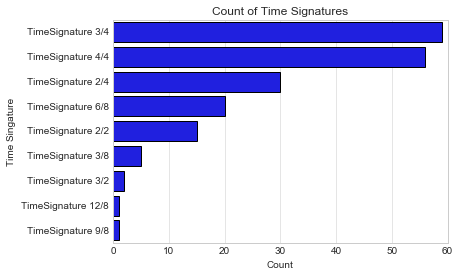

In [14]:
sns.set_style("whitegrid")
time_df = time_df.sort_values("Counts", ascending=False)
ax = sns.barplot(x = time_df['Counts'], y = time_df['Time Signature'], data=time_df,
            label="Total", color="b")
ax.set(xlim=(0, 60), ylabel="Time Singature",
       xlabel="Count", title = "Count of Time Signatures")

## Scatter plot and Anomaly 

There appears to be an anomaly that is somehow connected to the pitch durations in music21. Below is a scatterplot of all the pitch frequencies compared to their durations.

There are rhythmic subdivision that are being translated oddly in the current iteration of music21. I have a few ideas on how to fix this issue and will pull request the solution I find if someone doesn't solve the anomaly before I get to it. 

Since many of the Bach chorales used in the DeepBach CSL project where short files around 20 to 100 measures or so, chopping up the string quartet files into 20 measure sequences seemed adventageous to reduce the noice in the observations. However many of the files written to midi using music21 were not trainable and did not retain schema and metadata about the files, see below from a sliced section of Beethovens 4th string quartet.

Time permitting I will figure out how to slice the large files by time or measures using another package.

In [15]:
x = PitchData.groupby(['NoteDuration', 'NoteFreq'])['str_NoteAndDuration'].count()
x = x.reset_index()
x.columns = ['NoteDuration', 'NoteFreq', 'Count']

<function matplotlib.pyplot.close>

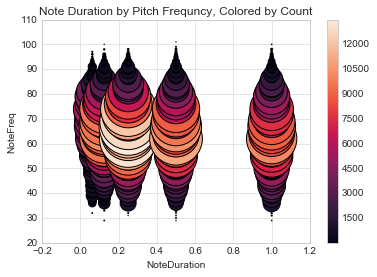

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

points = plt.scatter(x['NoteDuration']
            , x['NoteFreq']
            , c = x['Count']
            , s = (x['Count']/4))

plt.colorbar(points)

sns.regplot("NoteDuration", 'NoteFreq', data=x, scatter=False, fit_reg = False, color=".1")

plt.title("Note Duration by Pitch Frequncy, Colored by Count")
plt.close

Below is a music score, which could also be interpreted as a time series plot. The lack of a triplet based subdivision, ~.33 seems odd.

__*In the section below, there is an anamoly with the triplet passages in which the note duration continues, seemingly infinitely.*__

When the rhythms become smaller subdivisions, somthing breaks down in the music21 midi class and below you can see the anamoly of the duration of notes being tied way past how they are composed to be.

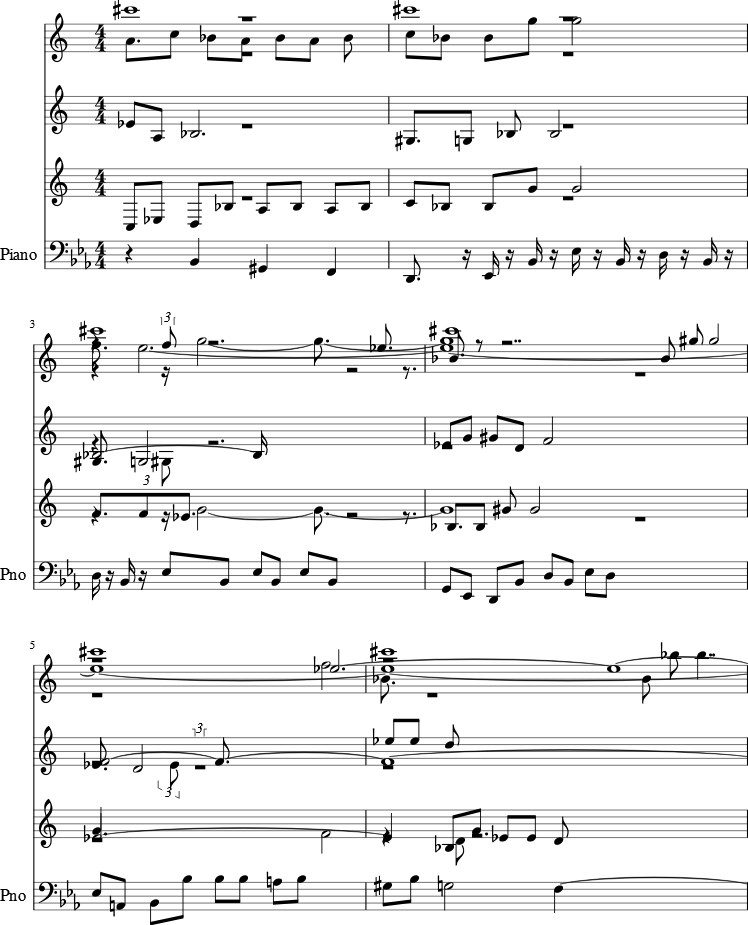

In [29]:
from music21 import *
a = converter.parse("C:\\Users\\qh1444dd\\Desktop\\Clean Beethoven\\quartet_4_1_(c)edwards_ChoppedSection_3.mid")
a.measures(0, 10).show()